In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [1]:
from imports import *

## Image creation

In [2]:
# Load the matrices from CSV files into separate variables
file_names = ["v1203_noTPC_pe_matrix", "v0303_noTPC_time_matrix", "coated_pmt_map_realistic_flipped", "uncoated_pmt_map_realistic_flipped" ,"xarap_vis_map_realistic_flipped" , "xarap_vuv_map_realistic_flipped", "coated_pmt_map_compressed", "uncoated_pmt_map_compressed", "xarap_vis_map_compressed", "xarap_vuv_map_compressed"]

for i, name in enumerate(file_names):
    if i < 2:  # The first two files as float
        locals()[name] = np.loadtxt(f"saved_archives/pe_matrix_&_time_matrix/{name}.csv", delimiter=",")
    elif 2 <= i < 6:  # The next two files as int
        locals()[name] = np.loadtxt(f"saved_archives/maps/realistic/flipped/{name}.csv", delimiter=",", dtype=int)
    else:  # The remaining files as int
        locals()[name] = np.loadtxt(f"saved_archives/maps/compressed/{name}.csv", delimiter=",", dtype=int)

### Map creation

In [3]:
image = image_creator_gen_onlype(v1203_noTPC_pe_matrix, coated_pmt_map_realistic_flipped, uncoated_pmt_map_realistic_flipped, xarap_vis_map_realistic_flipped, xarap_vuv_map_realistic_flipped)

In [4]:
print(image.shape)

(21964, 59, 70, 8)


In [5]:
image_pmt = image_creator_gen_onlype(v1203_noTPC_pe_matrix, coated_pmt_map_realistic_flipped, uncoated_pmt_map_realistic_flipped)

In [6]:
image_xas = image_creator_gen_onlype(v1203_noTPC_pe_matrix, xarap_vis_map_realistic_flipped, xarap_vuv_map_realistic_flipped)

In [7]:
np.save("/data/vidales/images/image_v1203_onlype.npy", image)

In [8]:
np.save("/data/vidales/images/image_v1203_onlype_pmt.npy", image_pmt)
np.save("/data/vidales/images/image_v1203_onlype_xas.npy", image_xas)

## Visualization of generated images

### 4-component visualization

**load data**

In [ ]:
image = np.load("/data/vidales/images/image_vxxx.npy")

**Si tiene 16 capas de imagen por evento**

In [76]:
"""labels_2images = [
        "PE1: Coated PMT/Volume -", "PE2: Coated PMT/Volume +", "PE1: Uncoated PMT/Volume -", "PE2: Uncoated PMT/Volume +",
        "PE1: XA VIS/Volume -", "PE2: XA VIS/Volume +", "PE1: XA VUV/Volume -", "PE2: XA VUV/Volume +",
        "T1: Coated PMT/Volume -", "T2: Coated PMT/Volume +", "T1: Uncoated PMT/Volume -", "T2: Uncoated PMT/Volume +", 
        "T1: XA VIS/Volume -", "T2: XA VIS/Volume +", "T1: XA VUV/Volume -", "T2: XA VUV/Volume +"   
    ]"""


labels = [
        "PE1: Coated PMT/Volume +", "PE2: Coated PMT/Volume -", "T1: Coated PMT/Volume +", "T2: Coated PMT/Volume -",
        "PE1: Uncoated PMT/Volume +", "PE2: Uncoated PMT/Volume -", "T1: Uncoated PMT/Volume +", "T2: Uncoated PMT/Volume -",
        "PE1: XA VIS/Volume -", "PE2: XA VIS/Volume +", "T1: XA VIS/Volume -", "T2: XA VIS/Volume +",
        "PE1: XA VUV/Volume -", "PE2: XA VUV/Volume +", "T1: XA VUV/Volume -", "T2: XA VUV/Volume +"   
    ]


groups = [
        [0, 1, 4, 5],    # First group
        [2, 3, 6, 7],    # Second group
        [8, 9, 12, 13],  # Third group
        [10, 11, 14, 15] # Fourth group
    ]

grid =(4,4)
event_idx=1043

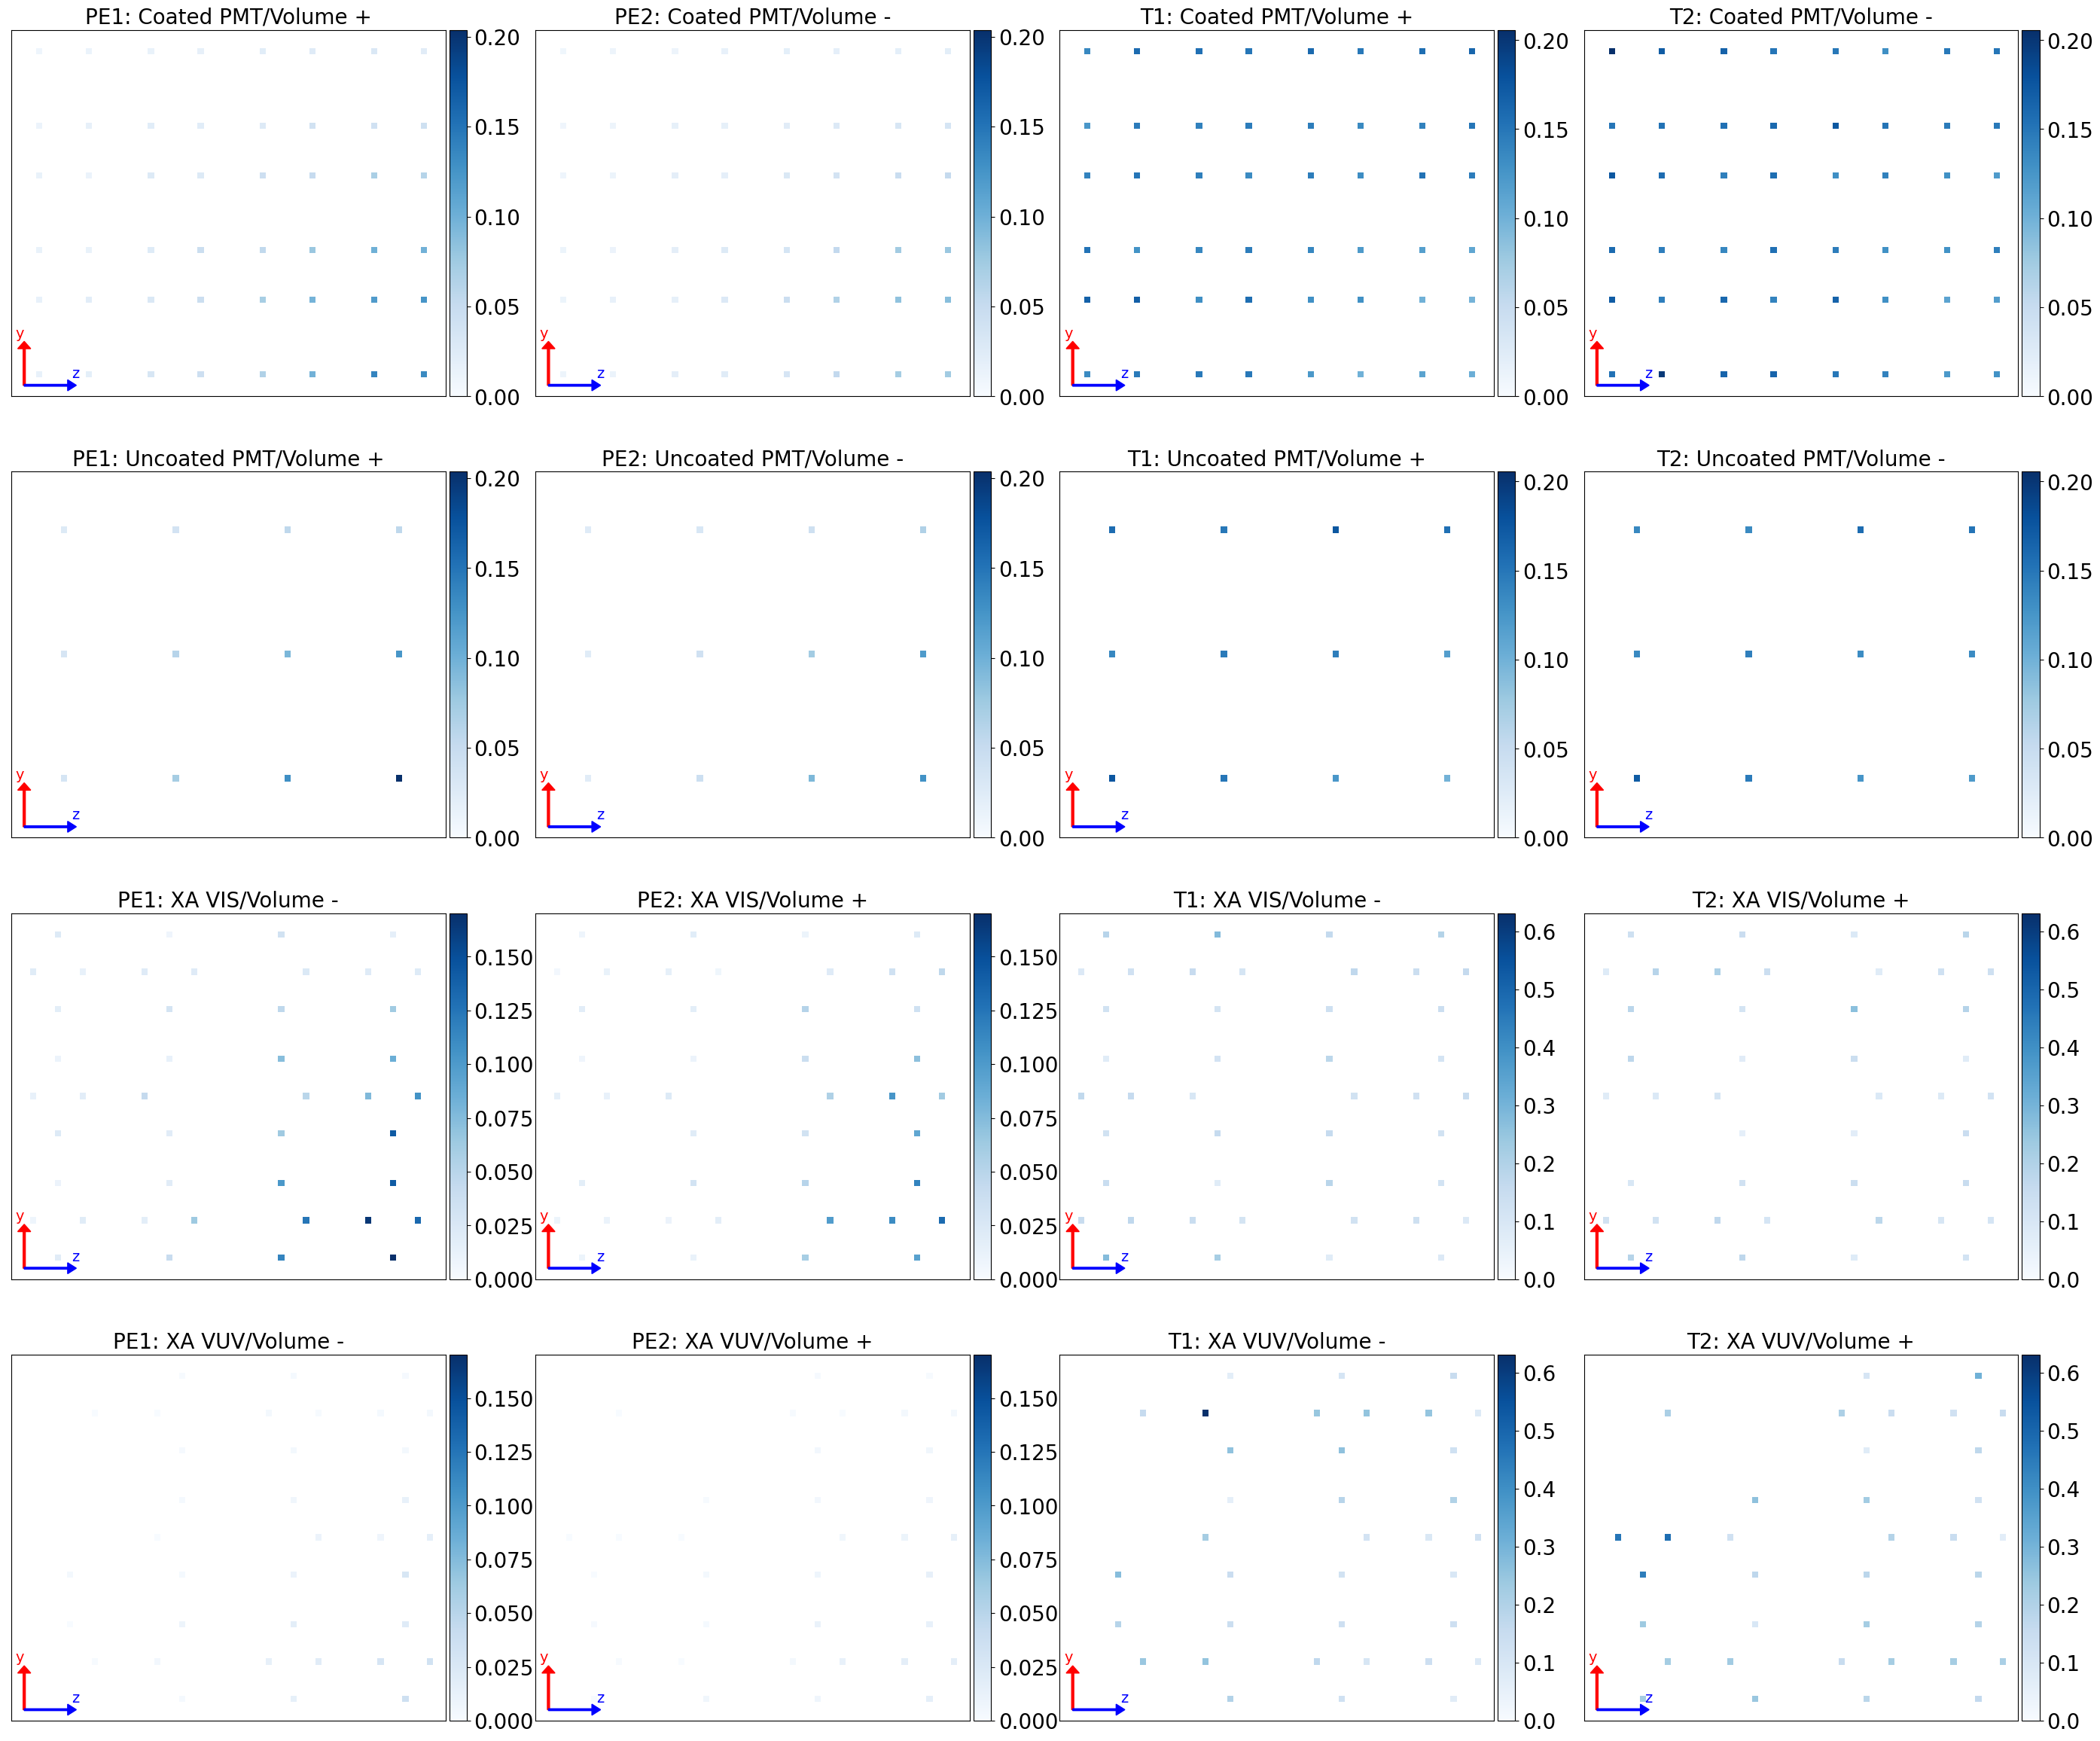

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Suponiendo que ya tienes las variables:
# image, event_idx, labels, groups, grid, etc.
# Ejemplo de datos para 16 subplots


use_log_scale = False
show_colorbar = True

# Define las dimensiones del grid y otras variables
num_rows, num_columns = grid
event_index = np.array([event_idx])

# Crear la figura y los ejes
fig, axs = plt.subplots(num_rows, num_columns, figsize=(num_columns * 7, num_rows * 5.9))
axs = axs.flatten()

# Configurar el mapa de colores
cmap = plt.cm.Blues.copy()
cmap.set_bad(color='white')

# Calcular las escalas para cada grupo
group_scales = {}
for group in groups:
    relevant_images = [np.squeeze(image[event_index[0], :, :, i]) for i in group]
    if use_log_scale:
        vmin = 1e-10  # Número positivo pequeño para la escala logarítmica
    else:
        vmin = 0
    vmax = max(np.max(img[img > 0]) if np.any(img > 0) else vmin for img in relevant_images)
    group_scales[tuple(group)] = (vmin, vmax)

# Parámetros para la posición y longitud de las flechas en coordenadas normalizadas
arrow_origin = (0.03, 0.03)  # Esquina inferior izquierda
arrow_length = 0.10          # Longitud de la flecha (en fracción del eje)

# Graficar las imágenes
for idx in range(len(labels)):
    # Extrae la imagen correspondiente
    img = np.squeeze(image[event_index[0], :, :, idx])
    masked_img = np.ma.masked_where(img <= 0, img)

    # Determina vmin y vmax según el grupo al que pertenezca idx
    for group, (vmin, vmax) in group_scales.items():
        if idx in group:
            if use_log_scale:
                im = axs[idx].imshow(masked_img, cmap=cmap,
                                     norm=LogNorm(vmin=vmin, vmax=vmax))
            else:
                im = axs[idx].imshow(masked_img, cmap=cmap, vmin=vmin, vmax=vmax)
            break

    # Título del subplot
    axs[idx].set_title(labels[idx], fontsize=20)

    # Agregar la barra de colores si se solicita
    if show_colorbar:
        divider = make_axes_locatable(axs[idx])
        cax = divider.append_axes("right", size="4%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax)
        cbar.ax.tick_params(labelsize=20)

    # ---- Flechas de ejes (Y y Z) usando ax.arrow ----
    # Eje Y (vertical hacia arriba)
    axs[idx].arrow(
        x=arrow_origin[0],
        y=arrow_origin[1],
        dx=0,
        dy=arrow_length,
        transform=axs[idx].transAxes,
        color='red',
        width=0.005,
        head_width=0.03,
        head_length=0.02
    )
    # Etiqueta del eje Y
    axs[idx].text(
        arrow_origin[0] - 0.02,
        arrow_origin[1] + arrow_length + 0.03,
        'y',
        color='red',
        fontsize=14,
        transform=axs[idx].transAxes
    )

    # Eje Z (horizontal hacia la derecha)
    axs[idx].arrow(
        x=arrow_origin[0],
        y=arrow_origin[1],
        dx=arrow_length,
        dy=0,
        transform=axs[idx].transAxes,
        color='blue',
        width=0.005,
        head_width=0.03,
        head_length=0.02
    )
    # Etiqueta del eje Z (a la derecha de la punta de la flecha)
    axs[idx].text(
        arrow_origin[0] + arrow_length + 0.01,
        arrow_origin[1] + 0.02,
        'z',
        color='blue',
        fontsize=14,
        transform=axs[idx].transAxes
    )
    # ---------------------------------

# Eliminar los ticks de todos los ejes
plt.setp(axs, xticks=[], yticks=[])

plt.tight_layout()
plt.show()

In [ ]:
plot_image(image_realistic_10, event_idx, labels, groups, grid, figsize=(30, 20), show_colorbar= True)

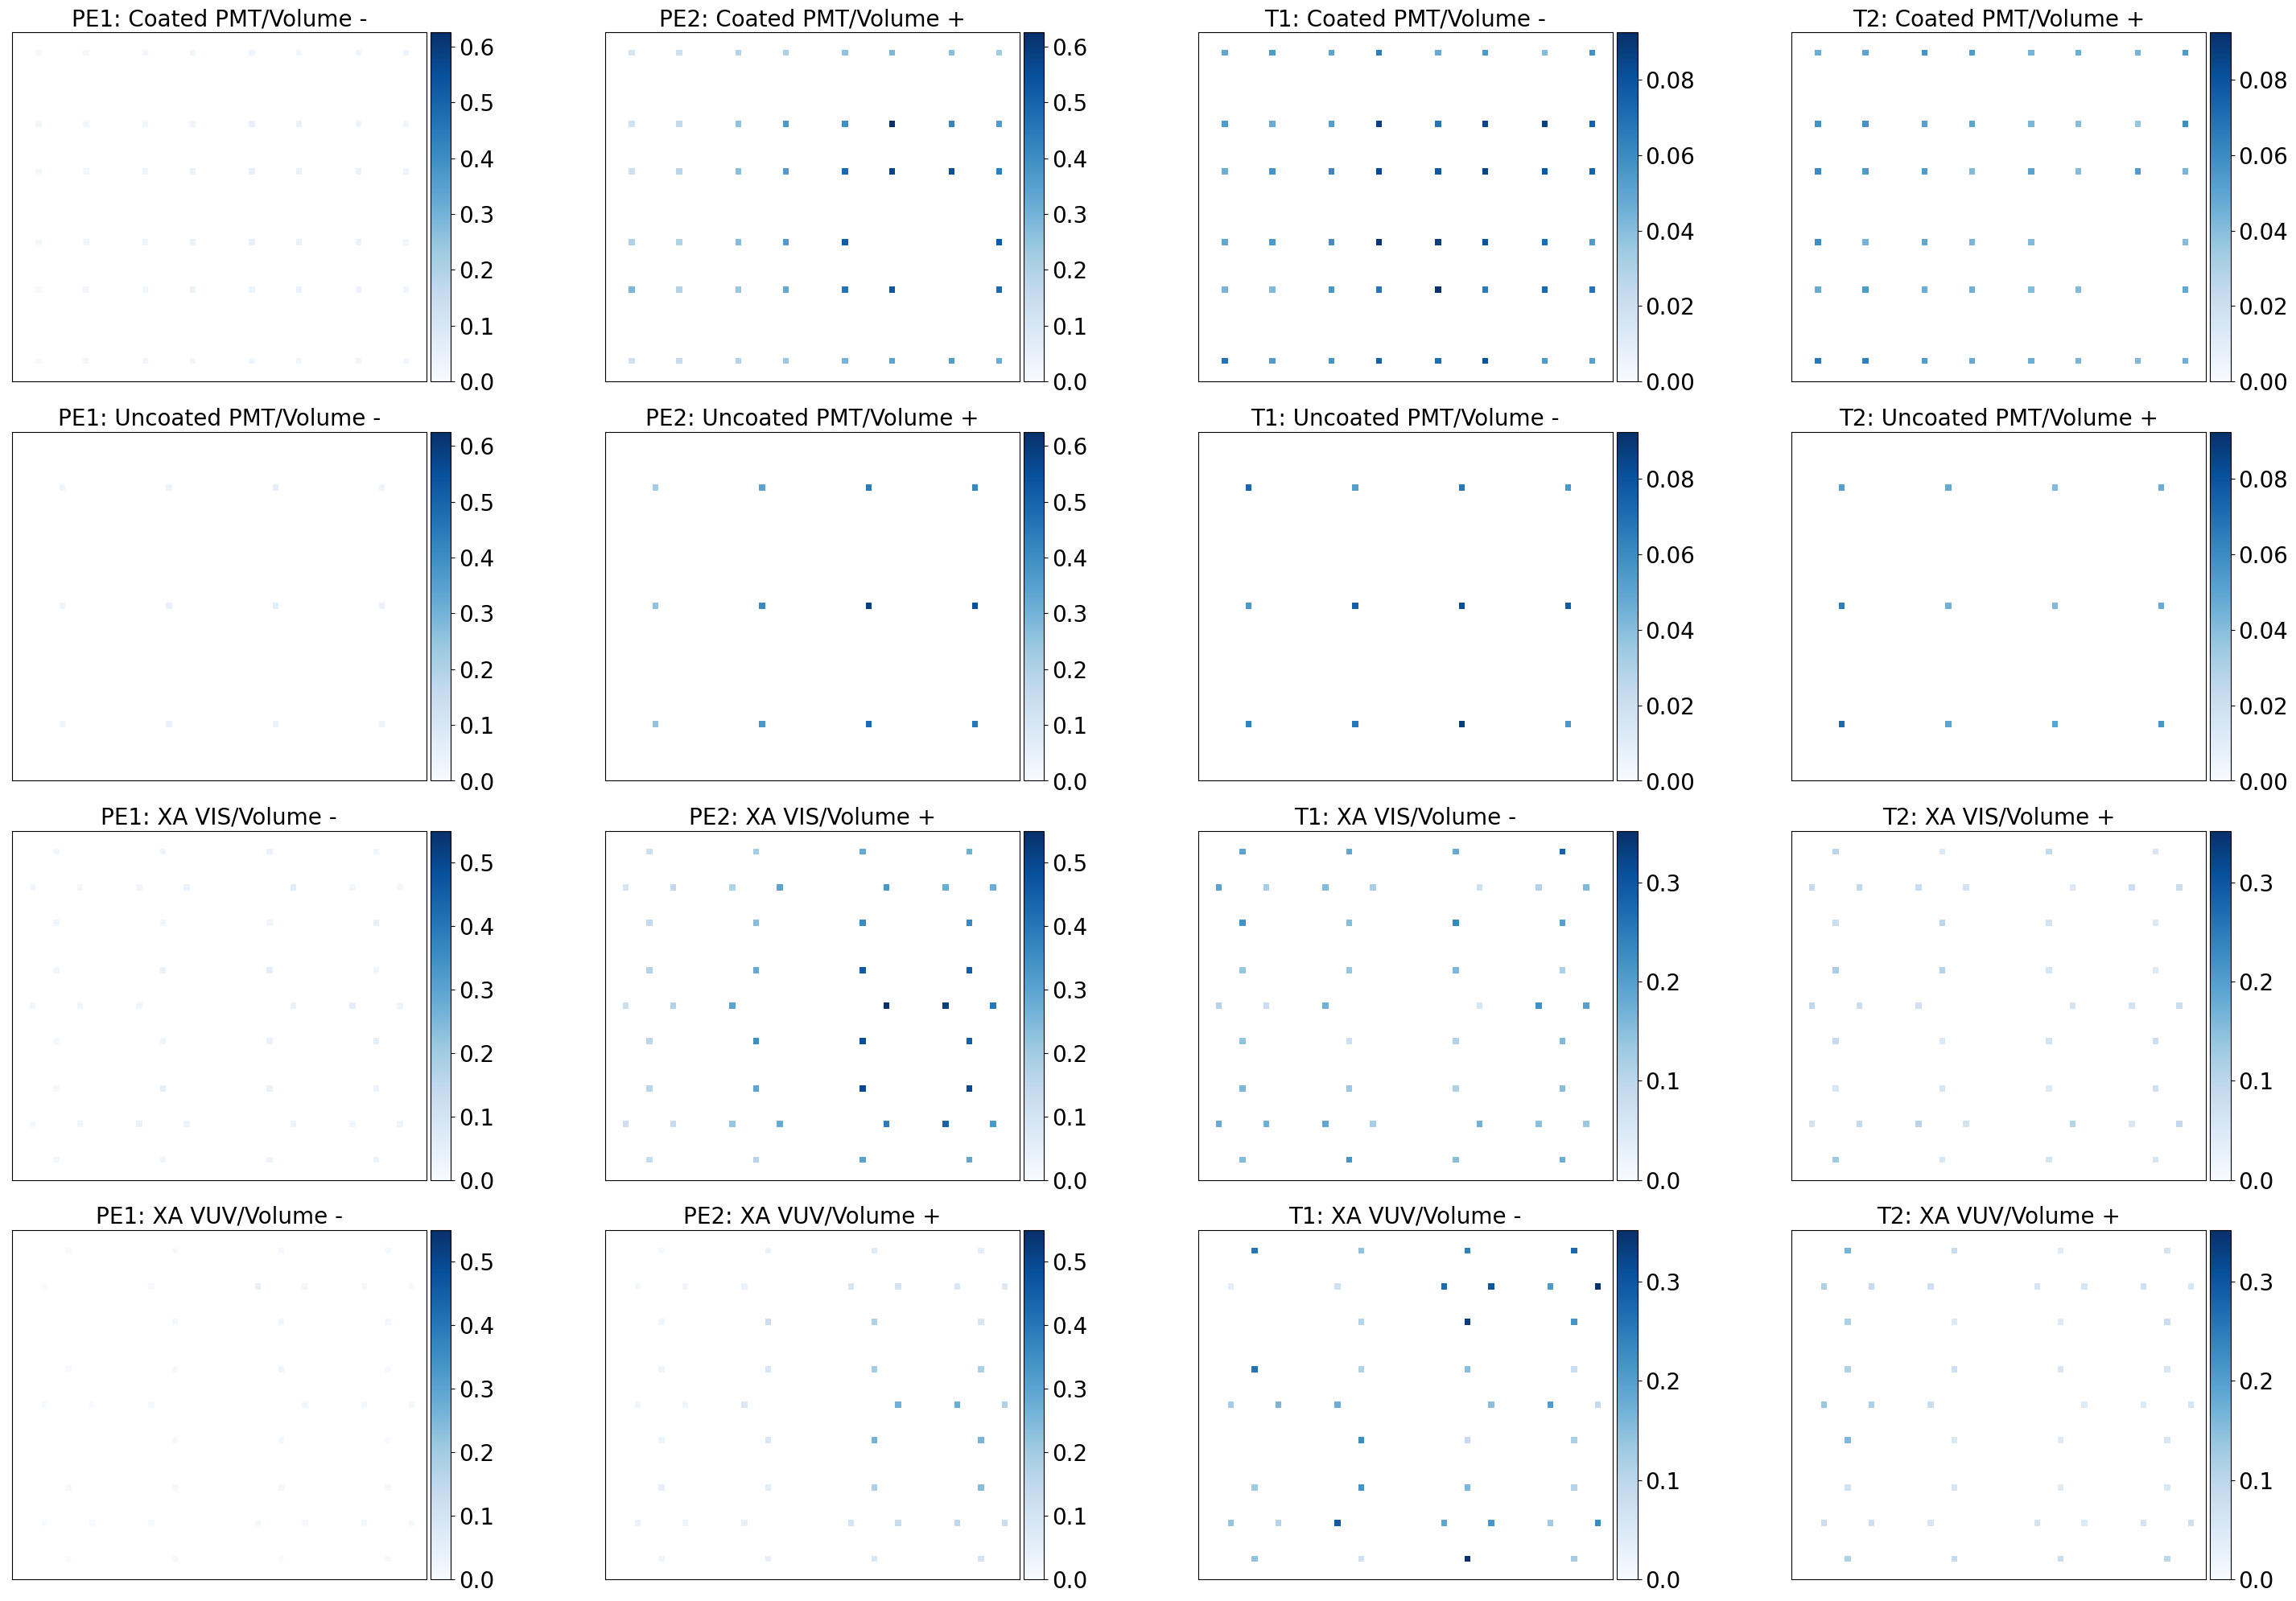

In [26]:
plot_image(image_realistic_10, event_idx, labels, groups, grid, figsize=(30, 20), show_colorbar= True)

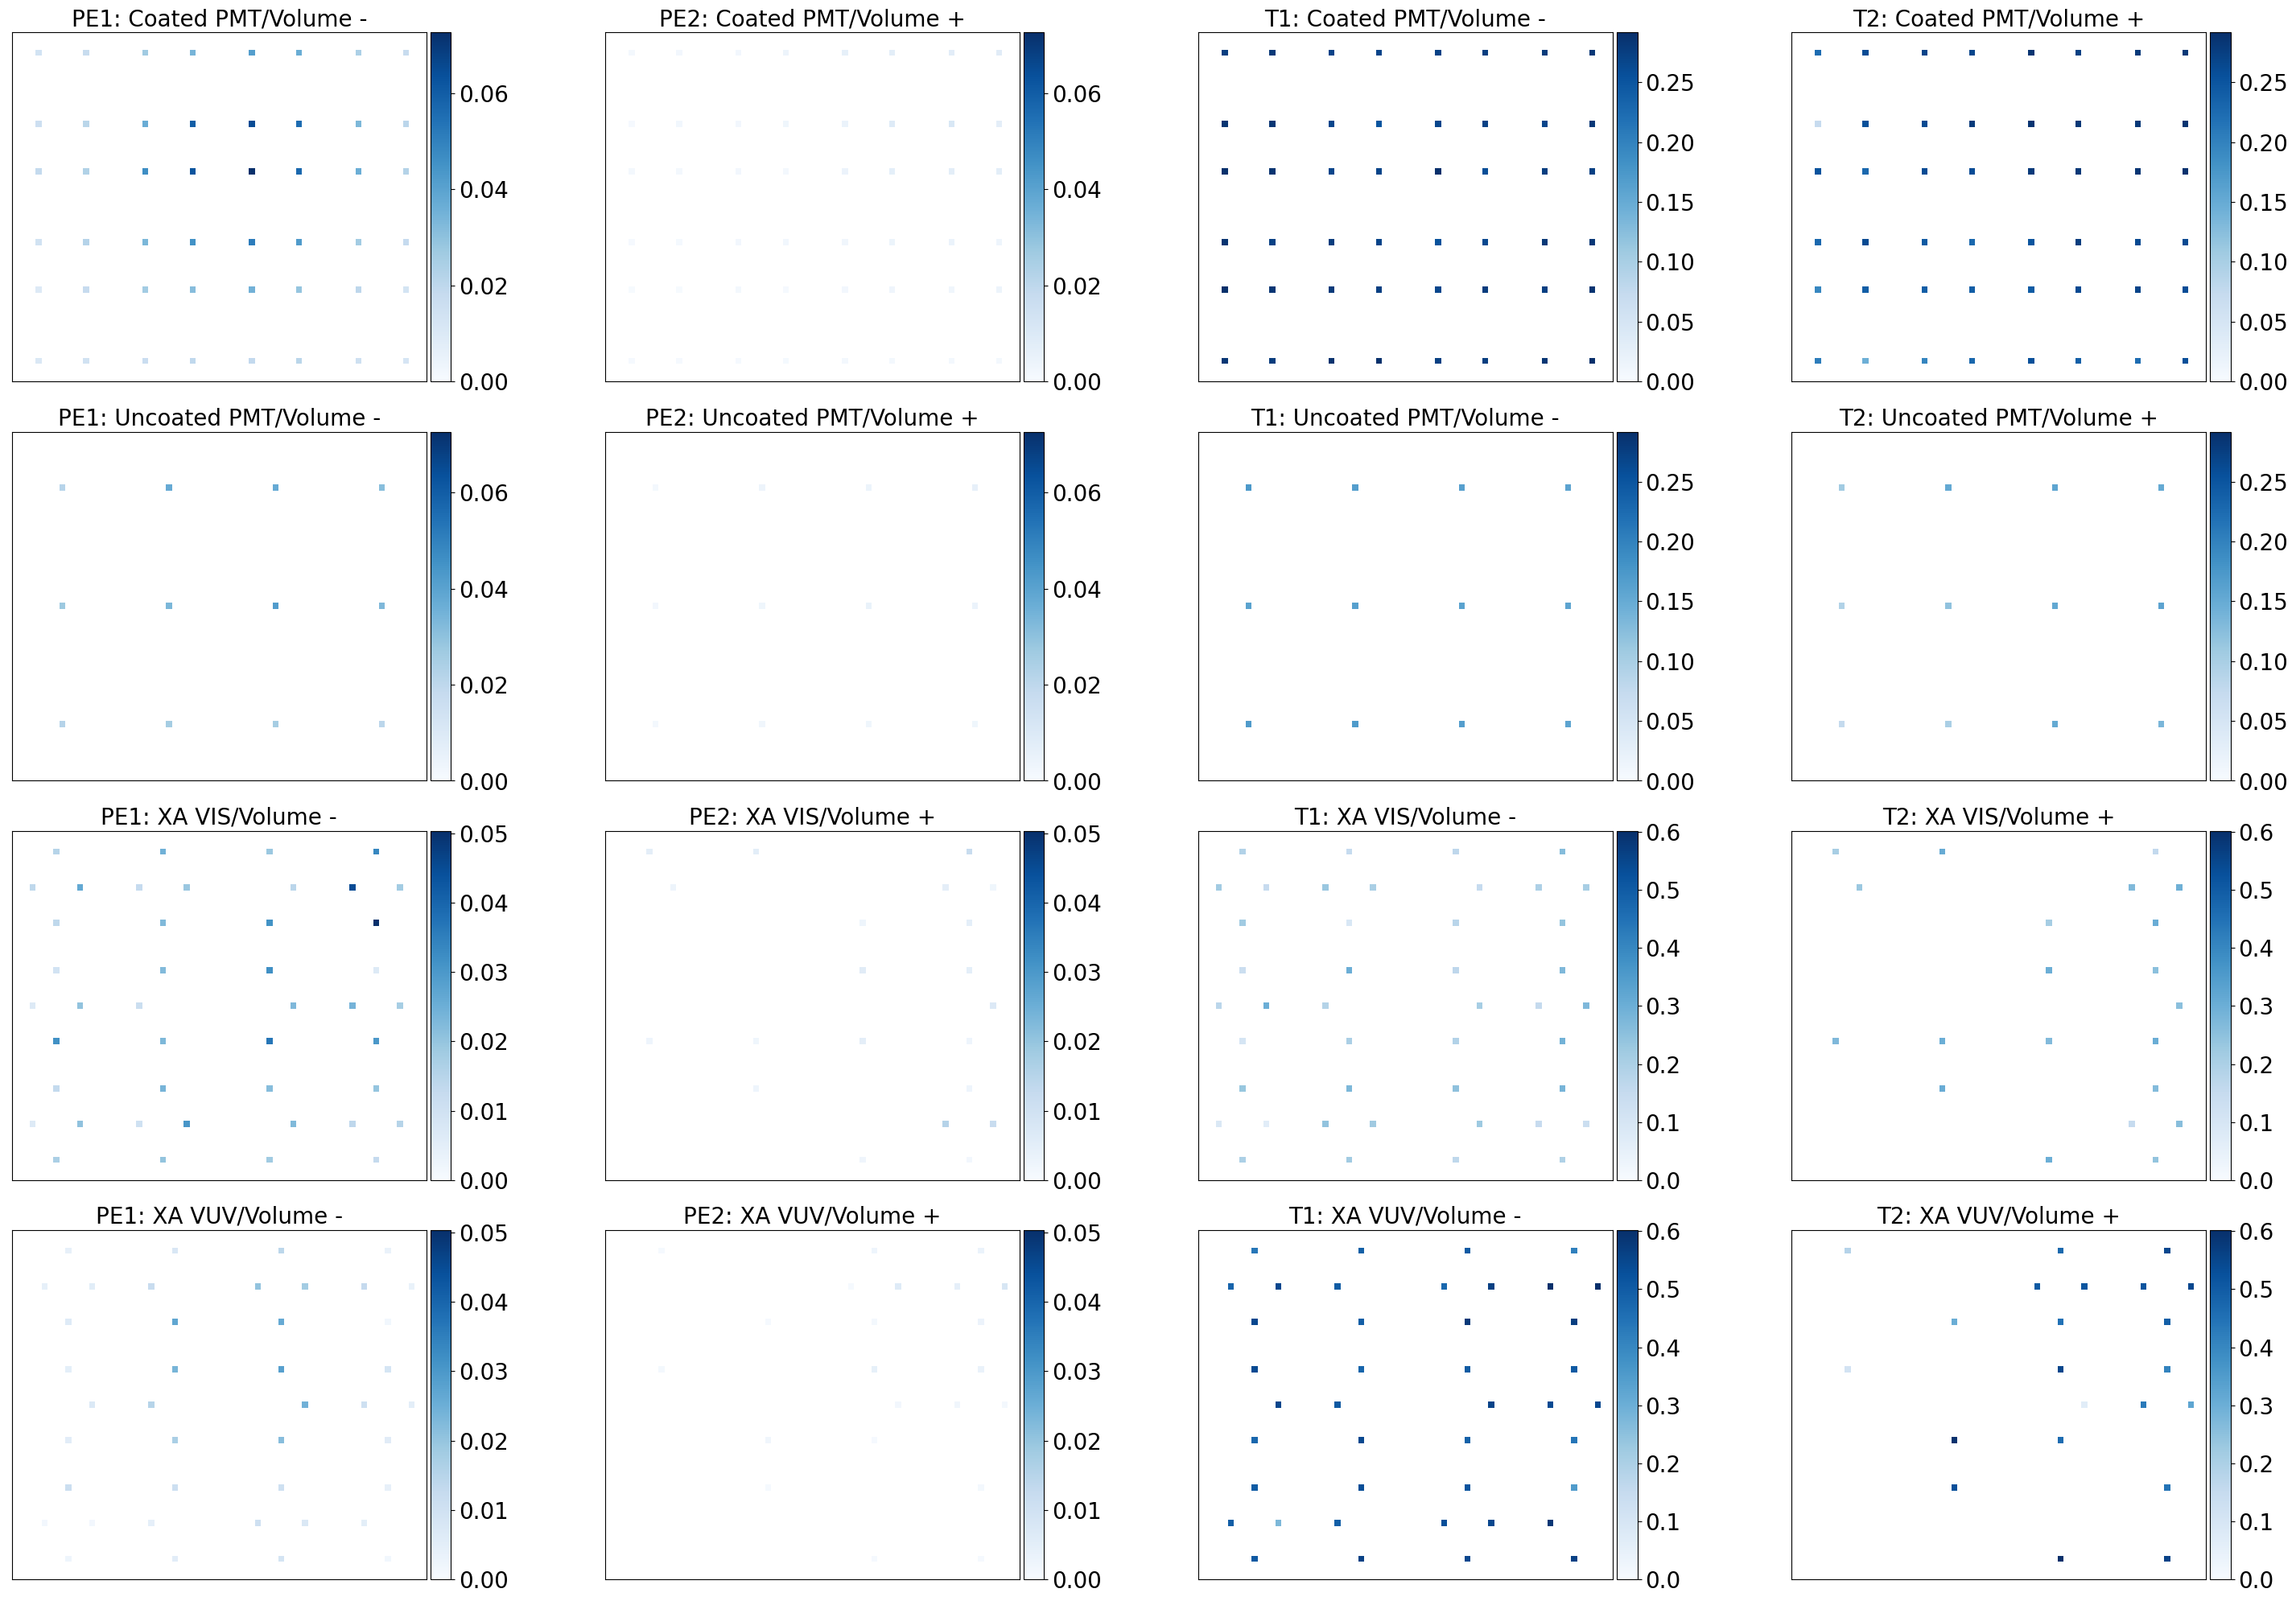

In [40]:
plot_image(image_realistic_inv, event_idx, labels, groups, grid, figsize=(30, 20), show_colorbar= True)

In [4]:
"""labels_2images = [
        "PE1: Coated PMT/Volume -", "PE2: Coated PMT/Volume +", "PE1: Uncoated PMT/Volume -", "PE2: Uncoated PMT/Volume +",
        "PE1: XA VIS/Volume -", "PE2: XA VIS/Volume +", "PE1: XA VUV/Volume -", "PE2: XA VUV/Volume +",
        "T1: Coated PMT/Volume -", "T2: Coated PMT/Volume +", "T1: Uncoated PMT/Volume -", "T2: Uncoated PMT/Volume +", 
        "T1: XA VIS/Volume -", "T2: XA VIS/Volume +", "T1: XA VUV/Volume -", "T2: XA VUV/Volume +"   
    ]"""


labels = [
        "PE1: Coated PMT/Volume -", "PE2: Coated PMT/Volume +", "T1: Coated PMT/Volume -", "T2: Coated PMT/Volume +",
        "PE1: Uncoated PMT/Volume -", "PE2: Uncoated PMT/Volume +", "T1: Uncoated PMT/Volume -", "T2: Uncoated PMT/Volume +",
        "PE1: XA VIS/Volume -", "PE2: XA VIS/Volume +", "T1: XA VIS/Volume -", "T2: XA VIS/Volume +",
        "PE1: XA VUV/Volume -", "PE2: XA VUV/Volume +", "T1: XA VUV/Volume -", "T2: XA VUV/Volume +"   
    ]


groups = [
        [0, 1, 4, 5],    # First group
        [2, 3, 6, 7],    # Second group
        [8, 9, 12, 13],  # Third group
        [10, 11, 14, 15] # Fourth group
    ]

grid =(4,4)
event_idx=1892

In [5]:
plot_image(image_realistic_noTPC, event_idx, labels, groups, grid, figsize=(30, 20), show_colorbar= True)

NameError: name 'image_realistic_noTPC' is not defined

**Si tiene ocho capas de imagen**

In [29]:
labels_pmts = [
        "PE1: Coated PMT", "PE2: Uncoated PMT", "T1: Coated PMT", "T2: Uncoated PMT",
        "PE3: XAs VIS", "PE4: XAs VUV","T1: XAs VIS", "T2: XAs VUV"
    ]
    
groups_pmts = [
        [0, 1], [2, 3],    # First group
        [4, 5], [6, 7]   # Second group
    ]

grid_pmts =(2,4)
event_idx=1893

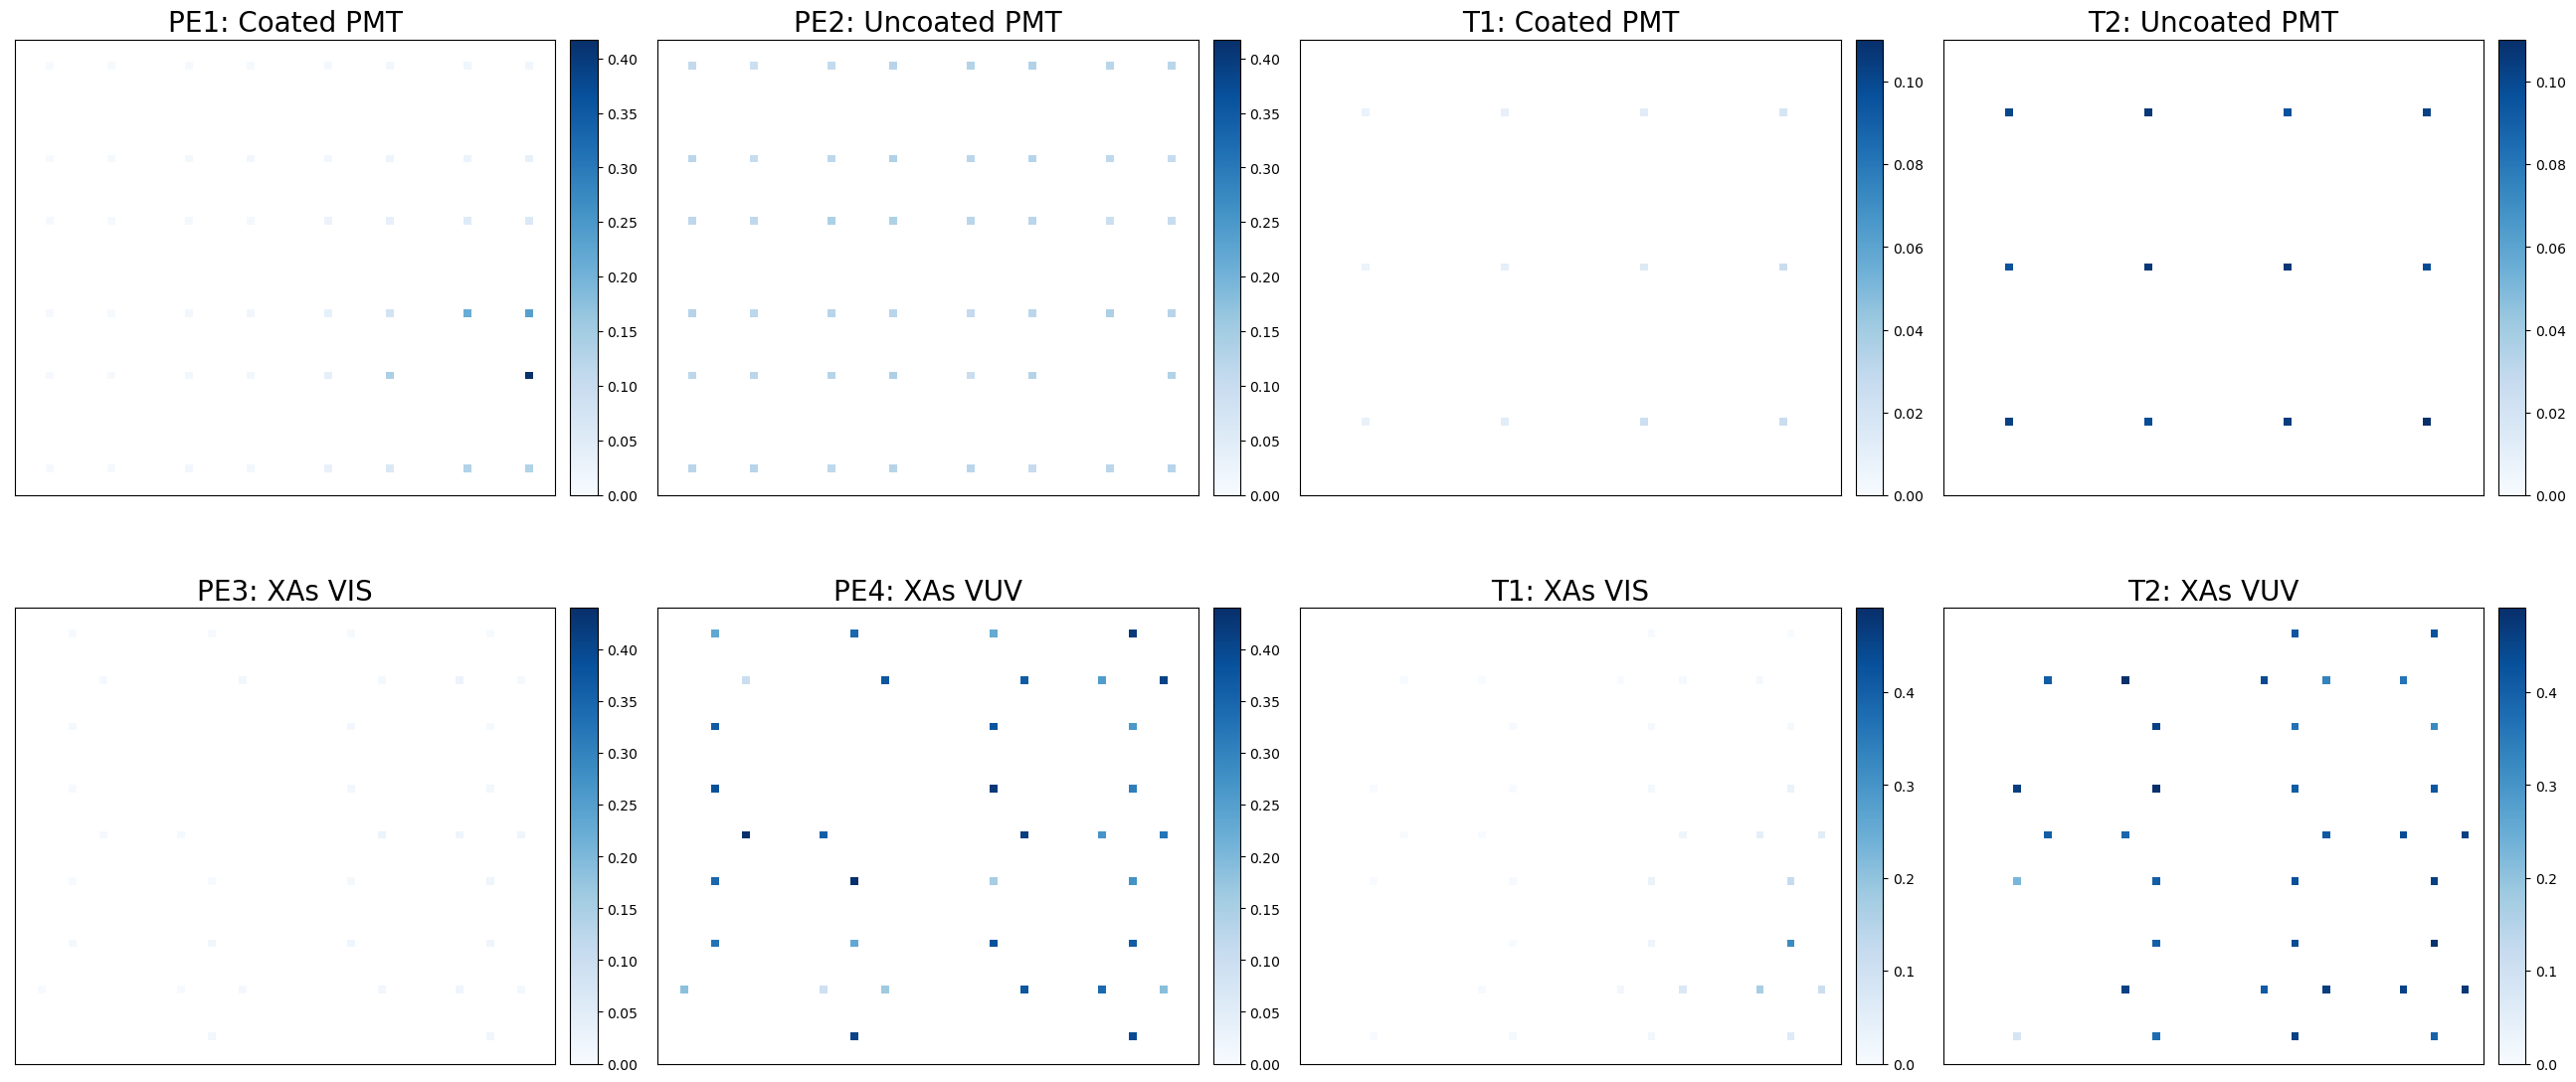

In [30]:
plot_image2(image_realistic, event_idx, labels_pmts, groups_pmts, grid_pmts, figsize=(26, 12))

In [83]:
print(np.unique(image_realistic_4comp_2[1497]))

[0.]


In [6]:
labels_xas = [
        "PE1: XA VIS/Volume -", "PE2: XA VIS/Volume +", "T1: XA VIS/Volume -", "T2: XA VIS/Volume +", 
        "PE1: XA VUV/Volume -", "PE2: XA VUV/Volume +", "T1: XA VUV/Volume -", "T2: XA VUV/Volume +"
    ]
    
groups_xas = [
        [0, 1, 4, 5],  # Third group
        [2, 3, 6, 7] # Fourth group
    ]

grid_xas =(2,4)
event_idx=590

In [9]:
image_compressed_4comp = np.load("/data/vidales/images/image_compressed_4comp_1411.npy")

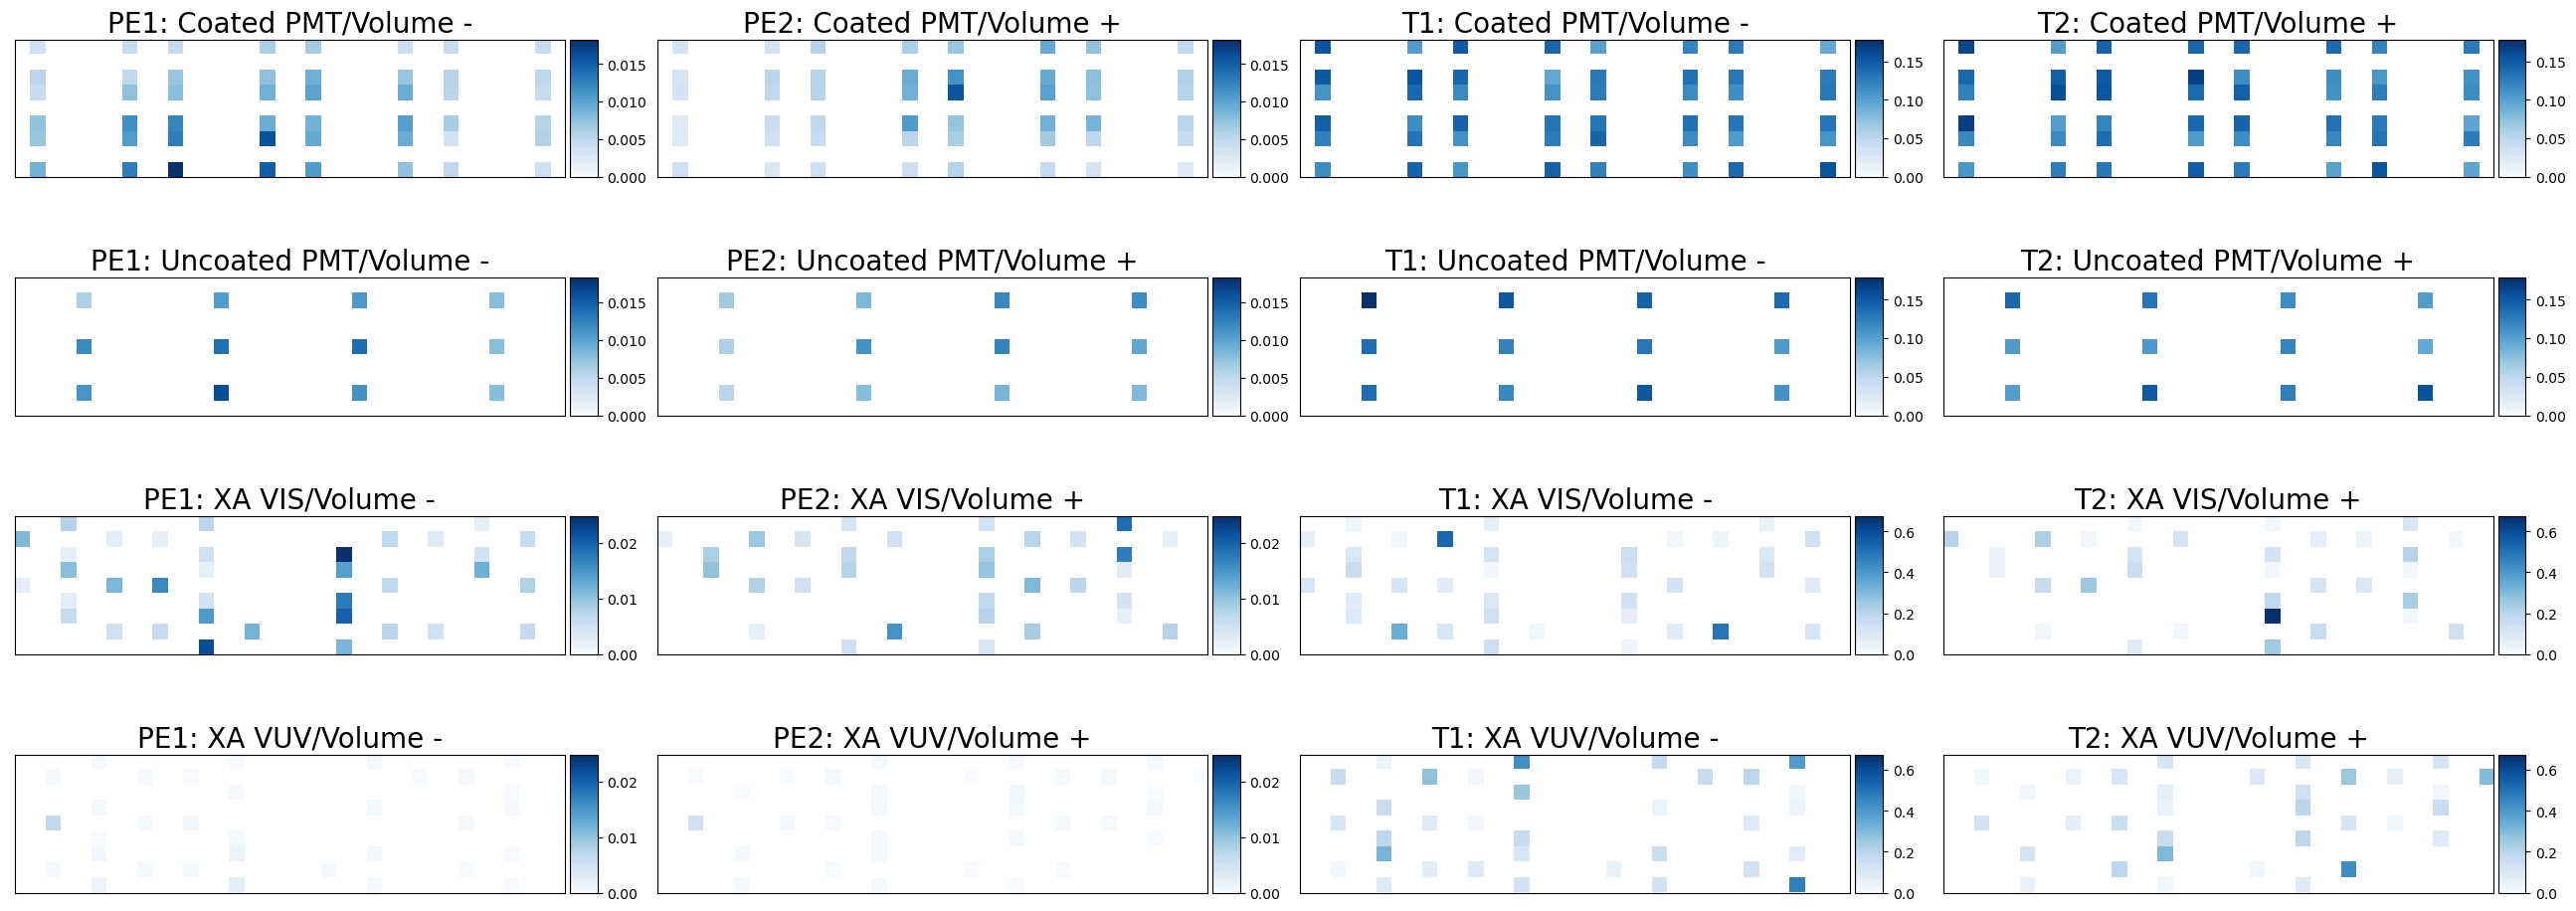

In [13]:
plot_image(image_compressed_4comp, event_idx, labels_4comp, groups_4comp, grid_4comp, figsize=(26, 10),show_colorbar=True)

In [15]:
print(np.shape(time_image_inv_30ns))
print(np.shape(time_image_inv_10ophits))

(21551, 59, 70, 8)
(21551, 59, 70, 8)


In [23]:
import numpy as np

# Suponiendo que las matrices se llaman matrix_1 y matrix_2
# matrix_1 y matrix_2 son de tamaño (21551, 59, 70, 8)

# Desviación estándar para matrix_1
dispersion_1 = np.std(time_image_inv_30ns, axis=(1, 2, 3))

# Desviación estándar para matrix_2
dispersion_2 = np.std(time_image_inv_10ophits, axis=(1, 2, 3))

print("Dispersion de matrix_1:", np.shape(dispersion_1))
print("Dispersion de matrix_2:", np.shape(dispersion_2))


Dispersion de matrix_1: (21551,)
Dispersion de matrix_2: (21551,)


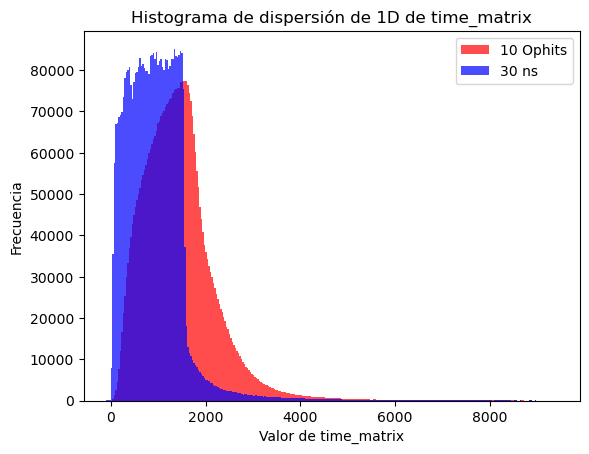

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming time_matrix_10ophits and time_matrix_30ns are your original matrices
time_matrix_10ophits_flattened = time_image_inv_10ophits_v2502.flatten()
time_matrix_30ns_flattened = time_image_inv_30ns_v2502.flatten()

# Filter out zeros
time_matrix_10ophits_flattened_nonzero = time_matrix_10ophits_flattened[time_matrix_10ophits_flattened != 0]
time_matrix_30ns_flattened_nonzero = time_matrix_30ns_flattened[time_matrix_30ns_flattened != 0]

# Create the histograms
plt.hist(time_matrix_10ophits_flattened_nonzero, bins=300, color='red', alpha=0.7, label='10 Ophits')
plt.hist(time_matrix_30ns_flattened_nonzero, bins=300, color='blue', alpha=0.7, label='30 ns')

# Labels
plt.title('Histograma de dispersión de 1D de time_matrix')
plt.xlabel('Valor de time_matrix')
plt.ylabel('Frecuencia')

# Add the legend
plt.legend()

# Show the plot
plt.show()


In [28]:
import numpy as np

indices_time_pmt = [2, 3, 6, 7]
indices_time_xarap = [10, 11, 14, 15]
time_mc_pmt_sample = new_image_mc_sample[:, :, :, indices_time_pmt]
time_mc_xarap_sample = new_image_mc_sample[:, :, :, indices_time_xarap]
indices_pe_pmt = [0, 1, 4, 5]
indices_pe_xarap = [8, 9, 12, 13]
pe_mc_pmt_sample = new_image_mc_sample[:, :, :, indices_pe_pmt]
pe_mc_xarap_sample = new_image_mc_sample[:, :, :, indices_pe_xarap]

In [15]:
print(new_image_mc_sample.shape)

(7337, 59, 70, 16)


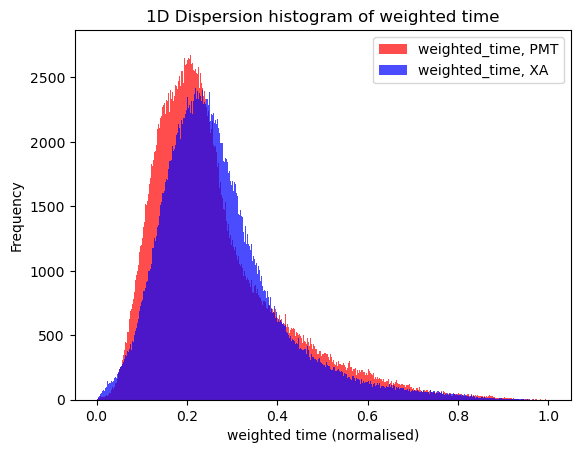

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming time_matrix_10ophits and time_matrix_30ns are your original matrices
time_matrix_pmt_10ophits_flattened = time_mc_pmt_sample.flatten()
time_matrix_xarap_10ophits_flattened = time_mc_xarap_sample.flatten()
pe_matrix_pmt_10ophits_flattened = pe_mc_pmt_sample.flatten()
pe_matrix_xarap_10ophits_flattened = pe_mc_xarap_sample.flatten()
# Filter out zeros
time_matrix_pmt_10ophits_flattened_nonzero = time_matrix_pmt_10ophits_flattened[time_matrix_pmt_10ophits_flattened != 0]
time_matrix_xarap_10ophits_flattened_nonzero = time_matrix_xarap_10ophits_flattened[time_matrix_xarap_10ophits_flattened != 0]
pe_matrix_pmt_10ophits_flattened_nonzero = pe_matrix_pmt_10ophits_flattened[pe_matrix_pmt_10ophits_flattened != 0]
pe_matrix_xarap_10ophits_flattened_nonzero = pe_matrix_xarap_10ophits_flattened[pe_matrix_xarap_10ophits_flattened != 0]


# Create the histograms
plt.hist(time_matrix_pmt_10ophits_flattened_nonzero, bins=1000, color='red', alpha=0.7, label='weighted_time, PMT')
plt.hist(time_matrix_xarap_10ophits_flattened_nonzero, bins=1000, color='blue', alpha=0.7, label='weighted_time, XA')
#plt.hist(pe_matrix_pmt_10ophits_flattened_nonzero, bins=1000, color='green', alpha=0.7, label='PE, PMT')
#plt.hist(pe_matrix_xarap_10ophits_flattened_nonzero, bins=1000, color='yellow', alpha=0.7, label='PE, XA')

# Labels
plt.title('1D Dispersion histogram of weighted time')
plt.xlabel('weighted time (normalised)')
plt.ylabel('Frequency')
#plt.ylim(0,5000)
# Add the legend
plt.legend()

# Show the plot
plt.show()
